# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB

We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - 37b5f64f


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving DeepSeek_R1.pdf to DeepSeek_R1.pdf


In [6]:
file_path = list(uploaded.keys())[0]
file_path

'DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
import uuid

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# QDrant Vector store setup without cache
vectorstore_without_cache = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=core_embeddings)
vectorstore_without_cache.add_documents(docs)
retriever_without_cache = vectorstore_without_cache.as_retriever(search_type="mmr", search_kwargs={"k": 3})

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [10]:
import time

def fetch_text_from_embeddings_with_time(query, retriever, retriever_without_cache):
    """Fetches text from embeddings using retriever and retriever_without_cache, and measures the time taken.

    Args:
        query: The query to search for.
        retriever: The retriever with cache.
        retriever_without_cache: The retriever without cache.

    Returns:
        A tuple containing the text fetched by retriever and retriever_without_cache, and the time taken for each.
    """
    # Fetch text using retriever (with cache) and measure time
    start_time_with_cache = time.time()
    docs_with_cache = retriever.get_relevant_documents(query)
    text_with_cache = [doc.page_content for doc in docs_with_cache]
    end_time_with_cache = time.time()
    time_with_cache = end_time_with_cache - start_time_with_cache

    # Fetch text using retriever_without_cache (without cache) and measure time
    start_time_without_cache = time.time()
    docs_without_cache = retriever_without_cache.get_relevant_documents(query)
    text_without_cache = [doc.page_content for doc in docs_without_cache]
    end_time_without_cache = time.time()
    time_without_cache = end_time_without_cache - start_time_without_cache

    return text_with_cache, text_without_cache, time_with_cache, time_without_cache

# Example usage
query = "Write 10 things about this document!"
text_with_cache, text_without_cache, time_with_cache, time_without_cache = fetch_text_from_embeddings_with_time(query, retriever, retriever_without_cache)

# Print the fetched text and time taken
print("Text with cache:", text_with_cache)
print("Time with cache:", time_with_cache)
print("Text without cache:", text_without_cache)
print("Time without cache:", time_without_cache)

<ipython-input-10-d3eba27954d1>:16: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs_with_cache = retriever.get_relevant_documents(query)


Text with cache: ['3.1. DeepSeek-R1 Evaluation\nBenchmark (Metric)\nClaude-3.5- GPT-4o DeepSeek OpenAI OpenAI DeepSeek\nSonnet-1022\n0513\nV3\no1-mini o1-1217\nR1\nArchitecture\n-\n-\nMoE\n-\n-\nMoE\n# Activated Params\n-\n-\n37B\n-\n-\n37B\n# Total Params\n-\n-\n671B\n-\n-\n671B\nEnglish\nMMLU (Pass@1)\n88.3\n87.2\n88.5\n85.2\n91.8\n90.8\nMMLU-Redux (EM)\n88.9\n88.0\n89.1\n86.7\n-\n92.9\nMMLU-Pro (EM)\n78.0\n72.6\n75.9\n80.3\n-\n84.0\nDROP (3-shot F1)\n88.3\n83.7\n91.6\n83.9\n90.2\n92.2\nIF-Eval (Prompt Strict)\n86.5\n84.3\n86.1\n84.8\n-\n83.3\nGPQA Diamond (Pass@1)\n65.0\n49.9\n59.1\n60.0\n75.7\n71.5\nSimpleQA (Correct)\n28.4\n38.2\n24.9\n7.0\n47.0\n30.1\nFRAMES (Acc.)\n72.5\n80.5\n73.3\n76.9\n-\n82.5\nAlpacaEval2.0 (LC-winrate)\n52.0\n51.1\n70.0\n57.8\n-\n87.6\nArenaHard (GPT-4-1106)\n85.2\n80.4\n85.5\n92.0\n-\n92.3\nCode\nLiveCodeBench (Pass@1-COT)\n38.9\n32.9\n36.2\n53.8\n63.4\n65.9\nCodeforces (Percentile)\n20.3\n23.6\n58.7\n93.4\n96.6\n96.3\nCodeforces (Rating)\n717\n759\n1134\n

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [12]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [13]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [14]:
import time

# Define a list of prompts
prompts = [
    "What is the capital of France?",
    "What is the highest mountain in the world?",
    "What is the population of Japan?",
]

# Time the LLM calls without caching
start_time = time.time()
for prompt in prompts:
    chat_model(prompt) # Assuming chat_model is defined as in your code
end_time = time.time()
print(f"LLM calls without caching took {end_time - start_time:.4f} seconds.")

# Time the LLM calls with caching
start_time = time.time()
for prompt in prompts:
    chat_model(prompt) # Assuming chat_model is defined as in your code
end_time = time.time()
print(f"LLM calls with caching took {end_time - start_time:.4f} seconds.")

<ipython-input-14-c6620a617cc3>:13: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  chat_model(prompt) # Assuming chat_model is defined as in your code


LLM calls without caching took 2.7789 seconds.
LLM calls with caching took 0.0043 seconds.


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [15]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [16]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "DeepSeek_R1."\n2. It is in PDF format (version 1.5).\n3. The document has a total of 22 pages.\n4. The specific page referenced here is page 12.\n5. The document was created using LaTeX with hyperref.\n6. The producer of the PDF is pdfTeX version 1.40.26.\n7. The creation date of the document is January 23, 2025.\n8. The modification date of the document is also January 23, 2025.\n9. The document includes an evaluation section titled "DeepSeek-R1 Evaluation."\n10. It benchmarks various metrics against models like Claude-3.5, GPT-4o, and others.\n11. The evaluation discusses activated and total parameters of different architectures.\n12. The DeepSeek model has 671 billion total parameters.\n13. The evaluation includes metrics like MMLU (Massive Multitask Language Understanding).\n14. The MMLU Pass@1 score for DeepSeek is 88.5.\n15. The MMLU-Redux (Exact Match) score for DeepSeek is 89.1.\n16. DeepSeek\'s MMLU-Pro score is 75.9.\n17. The DROP

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

In [19]:
from langsmith import Client
from langsmith import trace

langsmith_client = Client()

# Testing trace
with trace("Test Trace") as span:
    print("Trace started!")
    span.add_metadata({"example_key": "example_value"})
    print("Metadata added to trace!")
    time.sleep(1)
    print("Ending trace...")

Trace started!
Metadata added to trace!
Ending trace...


In [ ]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Define your function (if not already defined in your script)
def fetch_text_from_embeddings_with_time(query, retriever, retriever_without_cache):
    """Fetches text from embeddings using retriever and retriever_without_cache, and measures the time taken.

    Args:
        query: The query to search for.
        retriever: The retriever with cache.
        retriever_without_cache: The retriever without cache.

    Returns:
        A tuple containing the text fetched by retriever and retriever_without_cache, and the time taken for each.
    """
    # Fetch text using retriever (with cache) and measure time
    start_time_with_cache = time.time()
    docs_with_cache = retriever.get_relevant_documents(query)
    text_with_cache = [doc.page_content for doc in docs_with_cache]
    end_time_with_cache = time.time()
    time_with_cache = end_time_with_cache - start_time_with_cache

    # Fetch text using retriever_without_cache (without cache) and measure time
    start_time_without_cache = time.time()
    docs_without_cache = retriever_without_cache.get_relevant_documents(query)
    text_without_cache = [doc.page_content for doc in docs_without_cache]
    end_time_without_cache = time.time()
    time_without_cache = end_time_without_cache - start_time_without_cache

    return text_with_cache, text_without_cache, time_with_cache, time_without_cache

# Define the query
query = "Write 50 things about this document!"

with trace("Retrieval Augmented QA Chain Execution") as span:
    text_with_cache, text_without_cache, time_with_cache, time_without_cache = fetch_text_from_embeddings_with_time(
        query=query,
        retriever=retriever,
        retriever_without_cache=retriever_without_cache
    )

    # Log metadata properly
    span.add_metadata({
        "query": query,
        "retrieval_time_with_cache": time_with_cache,
        "retrieval_time_without_cache": time_without_cache
    })

    # End span
    span.end()

# Invoke the chain with cached retriever results
response_with_cache = retrieval_augmented_qa_chain.invoke({"question": query, "context": text_with_cache})

# Invoke the chain with non-cached retriever results
response_without_cache = retrieval_augmented_qa_chain.invoke({"question": query, "context": text_without_cache})

# Log chain responses in LangSmith
with trace("Chain Execution") as chain_span:
    chain_span.add_metadata({
        "question": query,
        "context_with_cache": text_with_cache,
        "context_without_cache": text_without_cache,
        "response_with_cache": response_with_cache,
        "response_without_cache": response_without_cache
    })
    chain_span.end()



# Print results
print("Response with cache:", response_with_cache)
print("Response without cache:", response_without_cache)
print("Time taken with cache:", time_with_cache)
print("Time taken without cache:", time_without_cache)

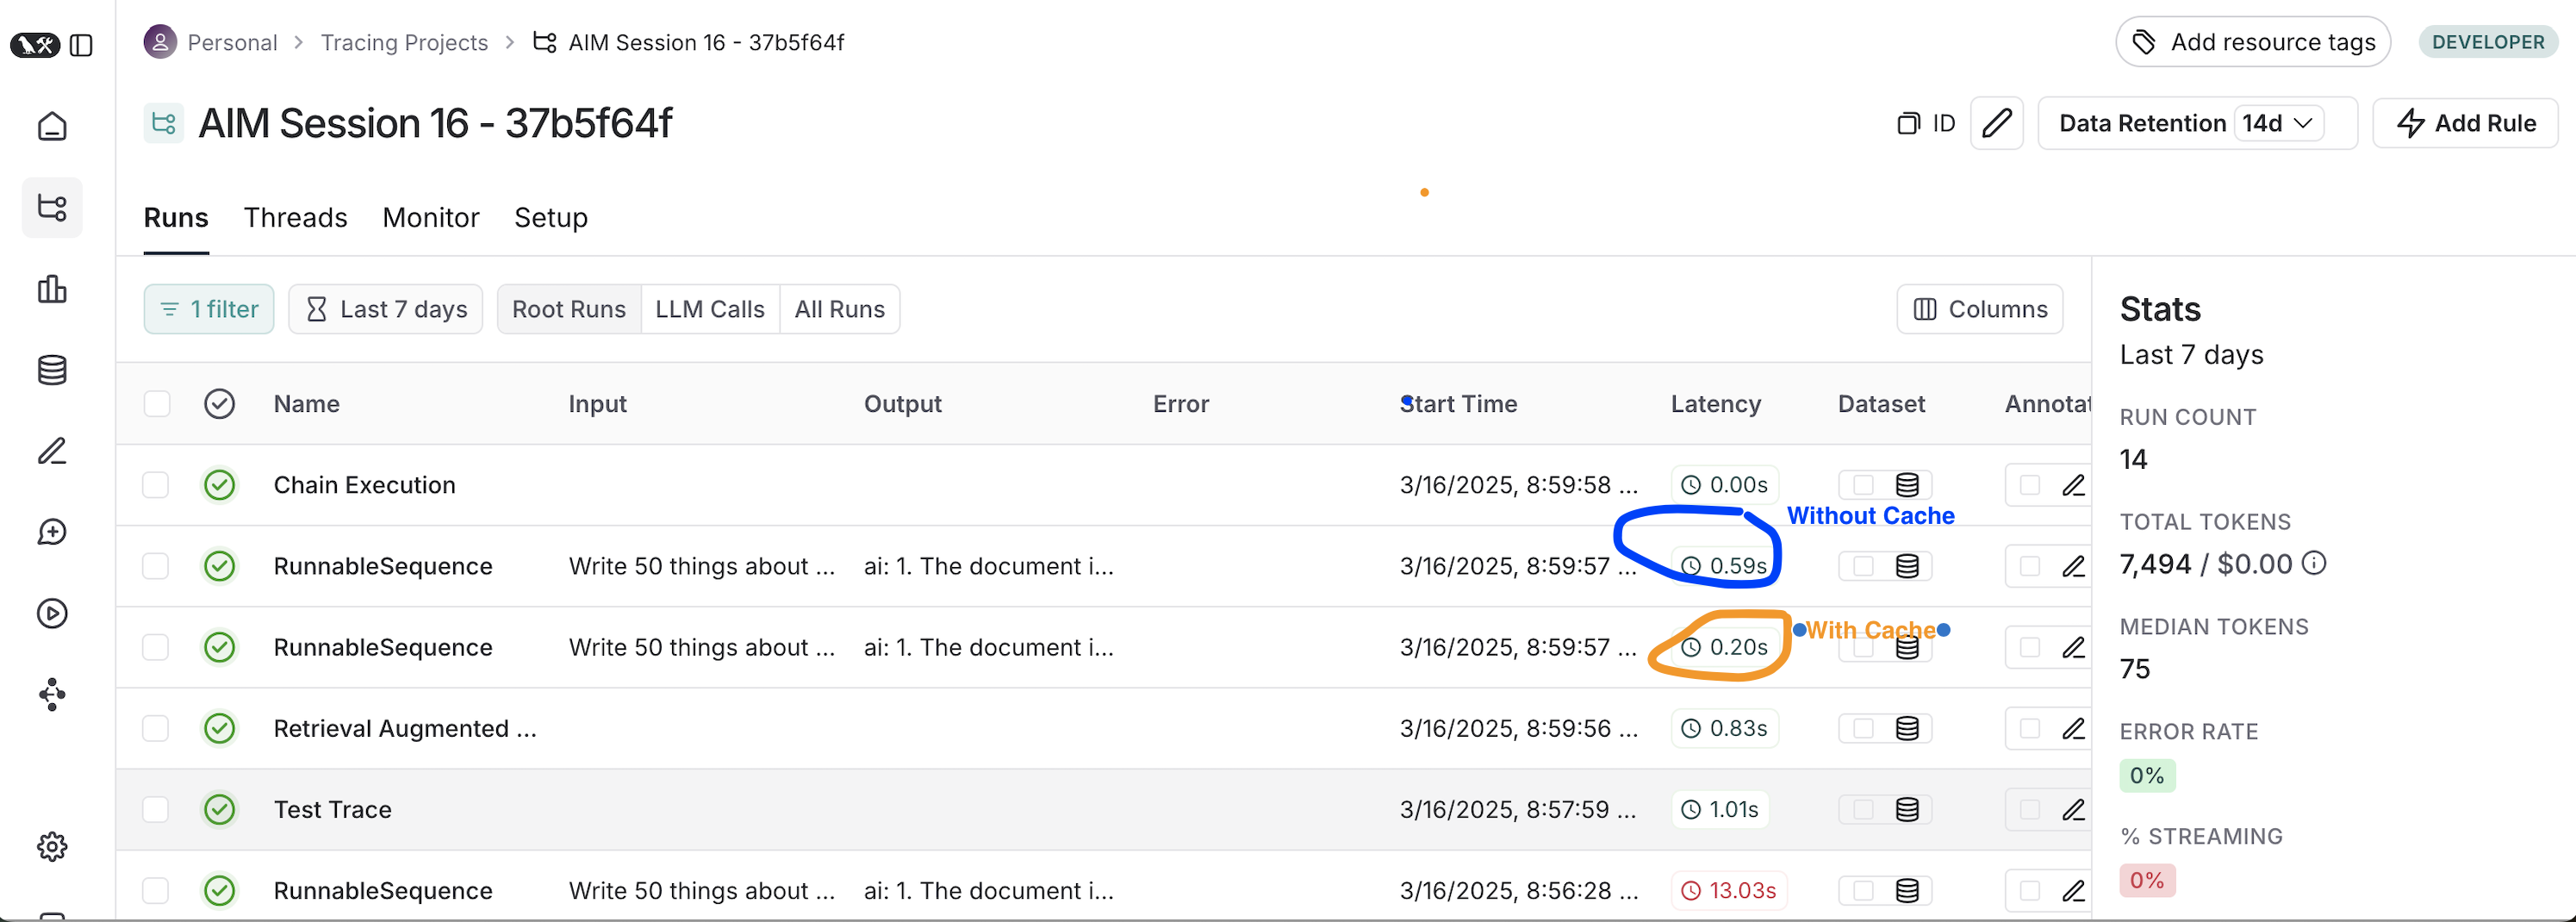